# **Identification of Fake Product Reviews**

---

## **Libraries**

In [1]:
import re
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud
import spacy

# Downloading required NLTK datasets
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')
nltk.download('vader_lexicon')

# Machine Learning and Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
import sklearn
import nltk
import spacy
import pandas
import numpy

print(f"scikit-learn: {sklearn.__version__}")
print(f"NLTK: {nltk.__version__}")
print(f"SpaCy: {spacy.__version__}")
print(f"Pandas: {pandas.__version__}")
print(f"NumPy: {numpy.__version__}")

# For python itself
import sys
print(f"Python: {sys.version}")

scikit-learn: 1.6.1
NLTK: 3.9.1
SpaCy: 3.8.5
Pandas: 2.2.2
NumPy: 2.0.2
Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


---

## **1.Dataset**

The dataset has four columns:
- `category`: product category
- `rating`: user rating (1,2,3,4,5)
- `text_`: review text
- `label`:
 - CG = Computer-generated (Fake reviews)
 - OR = Original reviews (Authentic reviews)

In [3]:
df = pd.read_csv("fake reviews dataset.csv") # load data

In [4]:
df.tail(20) # inspection

,category,rating,label,text_
40412,Clothing_Shoes_and_Jewelry_5,5.0,CG,"OMG, First reason why I chose this style is be..."
40413,Clothing_Shoes_and_Jewelry_5,5.0,OR,The cold damp fog tries to grab at my ankles a...
40414,Clothing_Shoes_and_Jewelry_5,4.0,CG,First off I returned this pair. The quality is...
40415,Clothing_Shoes_and_Jewelry_5,5.0,OR,I'd consider myself an advanced non-profession...
40416,Clothing_Shoes_and_Jewelry_5,3.0,CG,"When I saw this ring, I thought it was very be..."
40417,Clothing_Shoes_and_Jewelry_5,5.0,OR,I cannot thank my boss enough for recommending...
40418,Clothing_Shoes_and_Jewelry_5,2.0,CG,This bag weighs exactly 10pounds (I wear an XL...
40419,Clothing_Shoes_and_Jewelry_5,5.0,OR,Sometimes it is so hard to find a loose comfor...
40420,Clothing_Shoes_and_Jewelry_5,5.0,CG,I just bought these locally and they are the b...
40421,Clothing_Shoes_and_Jewelry_5,2.0,OR,"I'm a 36B, which means that I don't need any h..."


---

## **2.Preprocessing**

In [5]:
df_fe = df.copy() # to preserve raw data df

### **Data Cleaning**

**Missing values**

No missing values present.

In [6]:
print("Number of rows:", len(df_fe)) # total rows
print("Missing values per column:", df_fe.isnull().sum())
df_fe.dropna(inplace=True) # remove rows with missing values

Number of rows: 40432
Missing values per column: category    0
rating      0
label       0
text_       0
dtype: int64


**Feature encoding**

Converting text labels of the feature `label` to numerical values: CG to 1 and OR to 0.

In [7]:
# Encoding 'label': CG to 1, OR to 0
df_fe["label"] = df_fe["label"].map({"CG": 1, "OR": 0})

**Dropping columns**

Irrelevant feature because fake reviews can exist across all categories.

In [8]:
df_fe.drop('category', axis=1, inplace=True) # dropping 'category' column

**Text preprocessing**

Cleaning product reviews column.

In [9]:
df_fe['text_'] = df_fe['text_'].fillna('') # filling NaN with empty string
df_fe['text_'] = df_fe['text_'].astype(str) # ensuring values are all strings
df_fe['text_'] = df_fe['text_'].str.lower() # lowercase
df_fe['text_'] = df_fe['text_'].str.replace(r'\d+', '', regex=True) # removing numbers
df_fe['text_'] = df_fe['text_'].str.replace(r'[^\w\s]', '', regex=True) # removing punctuations

**Tokenisation**

Splitting text into individual words (tokens) for easier processing.

In [10]:
# Tokenizing text to store in a new column
df_fe['tokenized'] = df_fe['text_'].dropna().apply(word_tokenize)

In [11]:
df_fe.tail(3)

,rating,label,text_,tokenized
40429,2.0,0,you can wear the hood by itself wear it with t...,"[you, can, wear, the, hood, by, itself, wear, ..."
40430,1.0,1,i liked nothing about this dress the only reas...,"[i, liked, nothing, about, this, dress, the, o..."
40431,5.0,0,i work in the wedding industry and have to wor...,"[i, work, in, the, wedding, industry, and, hav..."


### **EDA**

**Wordcloud**

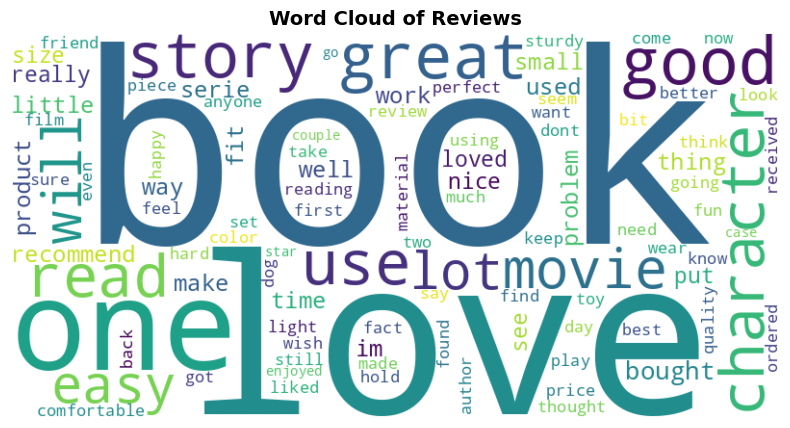

In [12]:
# Generating word cloud from reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(" ".join(df_fe['text_'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Reviews", fontsize=14, weight='bold')
plt.show()

**Review distribution**

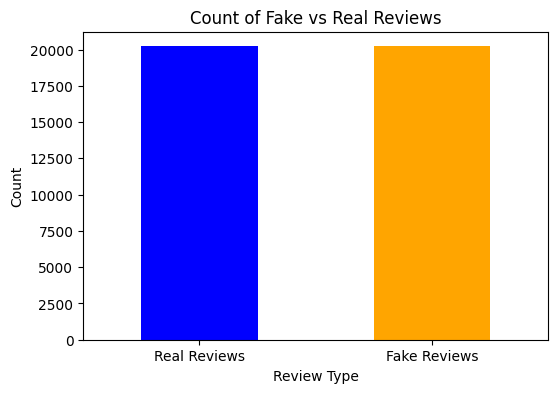

In [13]:
# Fake vs real reviews counts
df_fe['label'].value_counts().plot(kind='bar', color=['blue', 'orange'], figsize=(6,4), title="Count of Fake vs Real Reviews")
plt.xticks(ticks=[0,1], labels=['Real Reviews', 'Fake Reviews'], rotation=0)
plt.xlabel("Review Type"), plt.ylabel("Count"), plt.show();

### **Feature Extraction and Scaling**

#### **Linguistic Features**

Extracting patterns from words and sentences.

**Part-of-Speech (POS) Tagging**

POS tagging outputs how often each part of speech (like nouns, verbs, adjectives) appears in the reviews. For instance, a count of 3 for `"NOUN"` means there are three nouns in the review.

In [14]:
# Applying POS tagging and counting the types
pt_df = pd.DataFrame([Counter(tag for i, tag in pos_tag(text, tagset='universal')) for text in df_fe['tokenized']]).fillna(0)

In [15]:
pt_df.head()

,VERB,DET,NOUN,CONJ,ADV,ADJ,PRON,ADP,PRT,NUM,X
0,3.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,3.0,5.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0
2,2.0,3.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,3.0,2.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0
4,5.0,1.0,3.0,1.0,3.0,2.0,1.0,1.0,0.0,1.0,0.0


**Syntactic structures (Dependency Parsing)**

Syntactic structures refers to relationships of words in a sentence, and dependency parsing is used to count these relationships. In "The rabbit hop", the counts would be 1 for `"nsubj"` (subject: rabbit) and 1 for `"root"` (main verb: hop).

In [16]:
nlp = spacy.load("en_core_web_sm") # loading model for dependency parsing
dep_df = pd.DataFrame([Counter(token.dep_ for token in nlp(" ".join(text))) for text in df_fe['tokenized']]).fillna(0)

In [17]:
dep_df

,advcl,nsubj,advmod,relcl,oprd,cc,conj,ROOT,dobj,det,...,predet,appos,prt,expl,preconj,quantmod,csubjpass,agent,case,meta
0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40427,10.0,40.0,26.0,6.0,1.0,8.0,10.0,6.0,20.0,32.0,...,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40428,2.0,44.0,12.0,7.0,2.0,17.0,16.0,10.0,16.0,33.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40429,9.0,28.0,16.0,1.0,0.0,14.0,21.0,5.0,25.0,31.0,...,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
40430,1.0,42.0,24.0,4.0,1.0,22.0,15.0,17.0,20.0,29.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Behavioural Features**

**Review Length**

Number of words in each review is summed up.

In [18]:
df_fe['review_length'] = df_fe['tokenized'].str.len() # new column for review length

**Normalising**

Rating column is normalised. For example, rating of 3 is normalised to 0.5.

In [19]:
df_fe['normalized_rating'] = MinMaxScaler().fit_transform(df_fe[['rating']])
df_fe.drop('rating', axis=1, inplace=True) # drop unnormalised rating column

#### **Sentiment Features**

Sentiment features describes emotional tone of sentences, they can be quantified via negative, neutral, and positive scores. For instance, a strong positive sentiment like "I love using this product!" could have scores `neg: 0.0`, `neu: 0.2`, and `pos: 0.8`.

In [20]:
sia = SentimentIntensityAnalyzer()
full_sentiment = df_fe['text_'].apply(sia.polarity_scores) # applying sentiment analysis
full_sentiment_df = pd.DataFrame(full_sentiment.tolist()) # converting list of dictionaries into a DataFrame

In [21]:
negative_values = (full_sentiment_df < 0).sum() # checking for negative values using boolean
print(negative_values[negative_values > 0])

compound    4550
dtype: int64


In [22]:
sentiment_df = full_sentiment_df[['neg', 'neu', 'pos']] # dropping 'compound' column

In [23]:
sentiment_df.head()

,neg,neu,pos
0,0.000,0.258,0.742
1,0.000,0.509,0.491
2,0.000,0.611,0.389
3,0.079,0.642,0.279
4,0.000,0.719,0.281


### **Feature Selection**

In [24]:
# Joining all features
df_fs = pd.concat([df_fe, pt_df, dep_df, sentiment_df], axis=1) # feature selection
df_fs = df_fs.drop(columns=['text_', 'tokenized']) # dropping non-numerical features

In [25]:
df_fs.head()

,label,review_length,normalized_rating,VERB,DET,NOUN,CONJ,ADV,ADJ,PRON,...,expl,preconj,quantmod,csubjpass,agent,case,meta,neg,neu,pos
0,1,12,1.0,3.0,1.0,5.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.258,0.742
1,1,16,1.0,2.0,3.0,5.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.509,0.491
2,1,14,1.0,2.0,3.0,6.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.611,0.389
3,1,17,0.0,3.0,2.0,4.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079,0.642,0.279
4,1,18,1.0,5.0,1.0,3.0,1.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.719,0.281


**Feature importance**

Random Forest Classifier is trained on 80% of the data so feature importance can be ascertained. The plot shows how much contribution each feature made to model prediction.

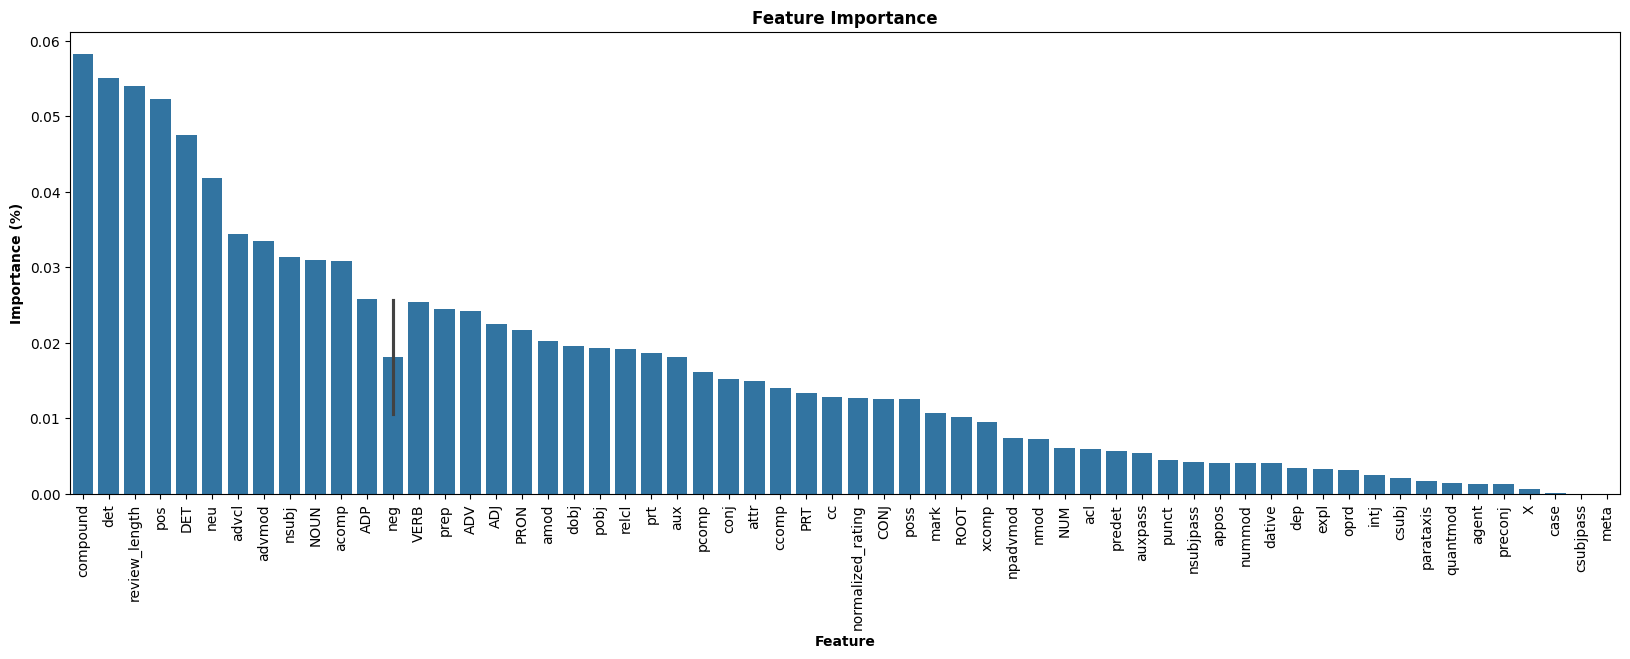

In [26]:
# Training Random Forest Classifier
X, y = df_fs.drop(columns='label'), df_fs['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

# Plotting feature importance scores from trained Random Forest model
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
plt.figure(figsize=[20,6])
sb.barplot(data=feat_imp, x='feature', y='importance')
plt.title('Feature Importance', weight='bold')
plt.xlabel('Feature',weight='bold')
plt.ylabel('Importance (%)',weight='bold')
plt.xticks(rotation=90)
plt.show()

---

## **3.Model Selection**

### **Preparation**

**Data Splitting**

In [27]:
X = df_fs.drop(columns=['label'])
y = df_fs['label'] # target variable

# Split data: 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**User-defined function for evaluating model**

Evaluates a single model using cross-validation and prints performance metrics.

In [28]:
def cross_validation(model, X, y, cv=5, model_name="Model"):
    metrics = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

    # Cross-validation
    results = cross_validate(model, X, y, cv=cv, scoring=metrics, return_train_score=True, n_jobs=-1)

    # DataFrame for results
    df_results = pd.DataFrame({
        "Metric": metrics,
        "Train Score": [results['train_' + m].mean() for m in metrics],
        "Validation Score": [results['test_' + m].mean() for m in metrics]})
    print(model_name, " Cross-Validation Results:")
    print(df_results.to_string(index=False))
    print("Mean Fit Time:", results['fit_time'].mean())

### **Logistic Regression**

In [29]:
# Pipeline for scaling and LogisticRegression classifier
pipeline_LR = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('LR', LogisticRegression(random_state=42, solver='saga'))]) # 'saga', good for large datasets

cross_validation(pipeline_LR, X_train, y_train, cv=5, model_name="Logistic Regression")

Logistic Regression  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.778868          0.777091
       f1     0.782788          0.781203
precision     0.770424          0.768434
   recall     0.795556          0.794444
  roc_auc     0.870728          0.869786
Mean Fit Time: 2.5173527240753173


### **Naive Bayes**

In [30]:
# Pipeline for scaling and multinomial Naive Bayes classifier
pipeline_NB = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))), # needs non-negative values so MinMaxScaler
    ('NB', MultinomialNB())])

cross_validation(pipeline_NB, X_train, y_train, cv=5, model_name="Naive Bayes")

Naive Bayes  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.622886          0.621178
       f1     0.676382          0.675031
precision     0.593112          0.591828
   recall     0.786852          0.785494
  roc_auc     0.675502          0.674826
Mean Fit Time: 0.05321755409240723


### **Decision Tree**

In [31]:
# Pipeline for scaling and decision tree classifier
pipeline_DT = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('DT', DecisionTreeClassifier(random_state=42))])

cross_validation(pipeline_DT, X_train, y_train, cv=5, model_name="Decision Tree")

Decision Tree  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy          1.0          0.712660
       f1          1.0          0.713656
precision          1.0          0.712386
   recall          1.0          0.715000
  roc_auc          1.0          0.712656
Mean Fit Time: 0.8366841793060302


### **Support Vector Machine**

In [32]:
# Pipeline for scaling and C-Support Vector classifier
pipeline_SVM = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('SVM', SVC(random_state=42))]) # kernel='rbf', Radial Basis Function, by default

cross_validation(pipeline_SVM, X_train, y_train, cv=5, model_name="SVM")

SVM  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.804808          0.800897
       f1     0.809261          0.805437
precision     0.792541          0.788770
   recall     0.826713          0.822840
  roc_auc     0.895593          0.892570
Mean Fit Time: 68.79906368255615


### **Random Forest**

In [33]:
# Pipeline for scaling and random forest classifier
pipeline_RF = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('RF', RandomForestClassifier(random_state=42))])

cross_validation(pipeline_RF, X_train, y_train, cv=5, model_name="Random Forest")

Random Forest  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.999992          0.820498
       f1     0.999992          0.820904
precision     0.999985          0.820473
   recall     1.000000          0.821358
  roc_auc     1.000000          0.902450
Mean Fit Time: 10.43918571472168


### **Adaptive Boosting**

In [34]:
# Pipeline for scaling and AdaBoost classifier
pipeline_AdaBoost = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('AdaBoost', AdaBoostClassifier(random_state=42))])

cross_validation(pipeline_AdaBoost, X_train, y_train, cv=5, model_name="AdaBoost")

AdaBoost  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.771595          0.770134
       f1     0.776848          0.775863
precision     0.760883          0.758580
   recall     0.793951          0.794321
  roc_auc     0.855928          0.853588
Mean Fit Time: 3.5297318935394286


### **K-nearest neighbours**

In [35]:
# Pipeline for scaling and k-nearest neighbours classifier
pipeline_KNN = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('KNN', KNeighborsClassifier())]) # n_neighbors=5 by default

cross_validation(pipeline_KNN, X_train, y_train, cv=5, model_name="k-nearest neighbours")

k-nearest neighbours  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.821348          0.720390
       f1     0.829562          0.737144
precision     0.794326          0.696605
   recall     0.868071          0.782716
  roc_auc     0.906164          0.789472
Mean Fit Time: 0.06344928741455078


### **Stacking**

From observations of results above, I formed this Stacking Classifier using Logistic Regression and Support Vector Machine, with Logistic Regression as the final estimator. My reasons for choosing the two base models are that Decision Tree, K-Nearest Neighbors, Random Forest showed overfitting, and Naive Bayes was inaccurate. AdaBoost was excluded because it is already an ensemble model.

In [36]:
base_models = [
    ('LR', LogisticRegression(random_state=42, solver='saga')),
    ('SVM', SVC(random_state=42))]

# Defining Stacking Classifier
stack = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

pipeline_stack = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('stack', stack)])

cross_validation(pipeline_stack, X_train, y_train, cv=5, model_name="Stacking Classifier")

Stacking Classifier  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.805681          0.801360
       f1     0.807591          0.803247
precision     0.801078          0.797039
   recall     0.814213          0.809568
  roc_auc     0.895500          0.892534
Mean Fit Time: 336.71405377388


---

## **4.Hyperparameter Optimization**

**Randomized Search**

In [37]:
# Defining hyperparameters
parameters = {
    'estimator': [DecisionTreeClassifier(max_depth=i) for i in [1,2,3]], # base learner depth
    'n_estimators': [50, 100, 200, 300], # number of trees
    'learning_rate': [0.01, 0.1, 0.5, 1.0]} # step size

# Initializing AdaBoost
adaboost = AdaBoostClassifier(random_state=42)

# Randomized Searching
random_search = RandomizedSearchCV(
    adaboost, parameters,
    n_iter=10, # try ten different combinations
    cv=3, # 3-fold cross-validation
    scoring='accuracy', # aiming for best accuracy
    n_jobs=-1, # parallel processing to speed up
    random_state=42)
random_search.fit(X_train, y_train)
print("Best AdaBoost Parameters:", random_search.best_params_)

Best AdaBoost Parameters: {'n_estimators': 300, 'learning_rate': 0.5, 'estimator': DecisionTreeClassifier(max_depth=3)}


**Optimised Hyperparameters**

In [38]:
# Pipeline for scaling and Tuned AdaBoost classifier
pipeline_AdaBoost_tuned = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('AdaBoost', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=300,
        learning_rate=0.5,
        algorithm='SAMME',
        random_state=42))])

cross_validation(pipeline_AdaBoost_tuned, X_train, y_train, cv=5, model_name="AdaBoost (Tuned)")

AdaBoost (Tuned)  Cross-Validation Results:
   Metric  Train Score  Validation Score
 accuracy     0.824146          0.814562
       f1     0.824931          0.815297
precision     0.822673          0.813251
   recall     0.827222          0.817469
  roc_auc     0.910698          0.902340
Mean Fit Time: 50.38752765655518


---

## **5.Final Model Training and Evaluation**

**Final Model Training**

In [39]:
# Pipeline for scaling and Tuned AdaBoost classifier
pipeline_final_model = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('AdaBoost', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=300,
        learning_rate=0.5,
        algorithm='SAMME',
        random_state=42))])

In [40]:
# Timing the model training
%time pipeline_final_model.fit(X_train, y_train)

# Prediction
y_pred = pipeline_final_model.predict(X_test)

# Prediction probabilities for ROC curve
y_pred_prob = pipeline_final_model.predict_proba(X_test)[:, 1] # Probabilities for class 1 (fake reviews)

# Calculating results
print("Final Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


CPU times: user 43.3 s, sys: 71.8 ms, total: 43.3 s
Wall time: 43.5 s
Final Model Results:
Accuracy: 0.8192160257202918
F1 Score: 0.8200836820083682
Precision: 0.810705596107056
Recall: 0.8296812749003984
ROC AUC: 0.9051390850256552


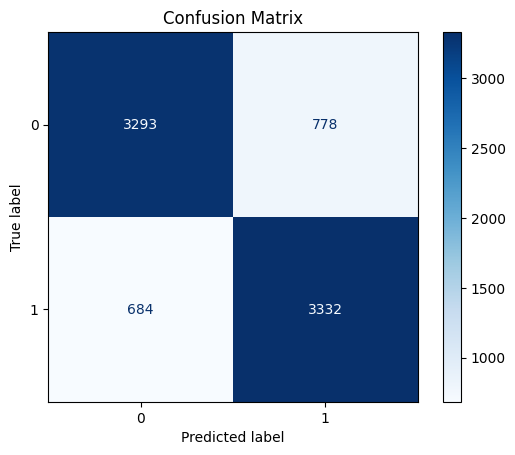

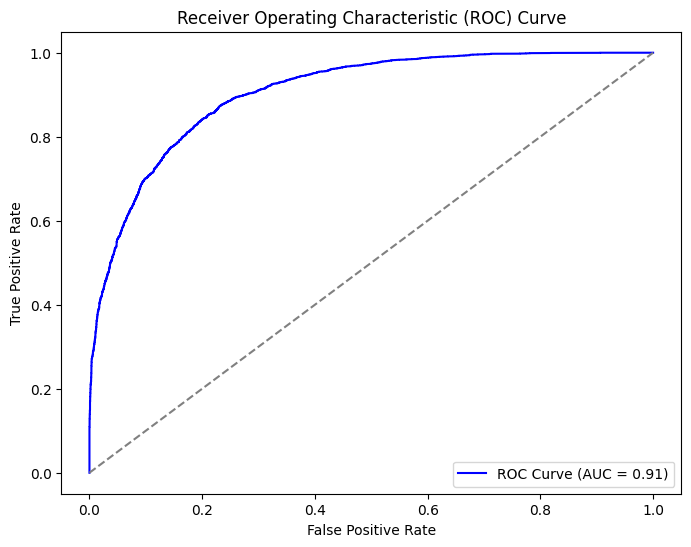

In [41]:
# Plotting Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plotting ROC curve (fpr, tpr, thresholds)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_prob)))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Save Trained Model**

In [42]:
with open('FakeReviewIdentifier_AI.pkl', 'wb') as f: # using pickle to save model
    pickle.dump(pipeline_final_model, f)